In [1]:
import random
from copy import deepcopy
from itertools import product
from pathlib import Path

import pandas as pd 
import numpy as np
import glob
from tqdm.notebook import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

import albumentations as A
from albumentations.pytorch import ToTensorV2
from imgaug import augmenters as iaa

from PIL import Image
from PIL.ExifTags import TAGS

import matplotlib.pyplot as plt
from IPython.display import clear_output

from transformers import (
    ViTForImageClassification, ViTFeatureExtractor, 
    LevitForImageClassification, LevitFeatureExtractor, 
    AutoFeatureExtractor, SwinForImageClassification,
)
from sklearn.model_selection import KFold

%matplotlib inline

# google/vit-base-patch16-224 facebook/levit-128S microsoft/swin-tiny-patch4-window7-224 facebook/deit-tiny-patch16-224 
model_name = "microsoft/swin-tiny-patch4-window7-224" 

device = "cuda"
BATCH_SIZE = 64
IMG_SIZE = 10496
TRAIN_IMG_SIZE = 224
IS_CNN = True
SEED = 42

def set_seed(seed: int = 1234, precision: int = 10) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.set_printoptions(precision=precision)

set_seed(SEED)

sigmoid = torch.nn.Sigmoid()        

In [21]:
def _compute_metric(
    data_true_batch, data_pred_batch, w = 10496, h = 10496
):
    result_metric = 0
    for data_true, data_pred in zip(data_true_batch, data_pred_batch):
        x_center_true = (data_true[0] + data_true[2]) / 2
        y_center_true = (data_true[1] + data_true[3]) / 2
        x_center_pred = (data_pred[0] + data_pred[2]) / 2
        y_center_pred = (data_pred[1] + data_pred[3]) / 2


        x_metr = abs(x_center_true - x_center_pred)
        y_metr = abs(y_center_true - y_center_pred)
        angle_metr = abs(data_true[4] - data_pred[4])

        metr = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * min(angle_metr, abs(angle_metr - 360))
        )
        result_metric += metr
    return result_metric / (len(data_true_batch) + 1)

In [22]:
class TorchLoss(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, y_pred, y_true):
        # input shape (batch_size, 5)
        batch_size = y_pred.shape[0]

        x_center_true = (y_true[..., 0] + y_true[..., 2]) / 2
        y_center_true = (y_true[..., 1] + y_true[..., 3]) / 2
        x_center_pred = (y_pred[..., 0] + y_pred[..., 2]) / 2
        y_center_pred = (y_pred[..., 1] + y_pred[..., 3]) / 2

        x_metr = torch.abs(x_center_true - x_center_pred)
        y_metr = torch.abs(y_center_true - y_center_pred)
        angle_metr = torch.abs(y_true[..., 4] - y_pred[..., 4])

        metric = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * torch.min(angle_metr, torch.abs(angle_metr - 360))
        )

        return -(metric.sum() / (batch_size + 1))


## Датасет


In [23]:
image = Image.open("../data/original.tiff")
exifdata = image.getexif()
tags = []
data = []
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data.append(exifdata.get(tag_id))
    # decode bytes 
    if isinstance(data[-1], bytes):
        data[-1] = data[-1].decode()
    tags.append(tag)
    # print(f"{tag:25}: {data}")

# print("TAGS")
# for tag in tags:
#     print(tag)
# print()

# for tag, d in zip(tags, data):
#     print(f"{tag:25}: {d}")

/home/and/miniforge3/envs/mipt-hack/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (110166016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [24]:
print(image.size)
IMG_SIZE = image.size[0]

(10496, 10496)


In [25]:
from math import sin, cos

json_dir = "../data/train/json/"


data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
rows = []
for _, _, files in os.walk(json_dir):
  for x in files:
    if x.endswith(".json"):
      data = json.load(open(json_dir + x))
      new_row = {
        'id':x.split(".")[0]+".png", 
        'left_top_x': data["left_top"][0], 
        'left_top_y': data["left_top"][1], 
        'right_bottom_x': data["right_bottom"][0], 
        "right_bottom_y": data["right_bottom"][1], 
        "x_center": (data["left_top"][0] + data["right_bottom"][0]) / 2,
        "y_center": (data["left_top"][1] + data["right_bottom"][1]) / 2,
        'angle': data["angle"]
    }
      rows.append(new_row)

data_df = pd.DataFrame(rows)

In [26]:
data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
0,796.png,1323,2706,2564,3451,1943.5,3078.5,346
1,319.png,2180,1805,1055,2716,1617.5,2260.5,96
2,928.png,7682,8425,7933,9852,7807.5,9138.5,35
3,1058.png,2899,9854,4298,9479,3598.5,9666.5,300
4,344.png,4302,7987,5663,8482,4982.5,8234.5,335


In [27]:
data_df.describe()

,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5666.133750,5687.818750,5693.117500,5687.990000,5679.625625,5687.904375,183.107500
std,2386.511565,2532.777585,2443.211258,2560.715173,2360.269448,2494.552756,105.093884
min,1028.000000,955.000000,941.000000,877.000000,1552.500000,1540.500000,0.000000
25%,3743.750000,3495.000000,3669.250000,3476.500000,3720.000000,3479.250000,90.750000
50%,5573.000000,5554.000000,5665.000000,5604.500000,5572.000000,5585.000000,183.500000
75%,7623.000000,7926.500000,7693.000000,7921.250000,7610.500000,7919.375000,273.000000
max,10614.000000,10642.000000,10688.000000,10648.000000,9964.500000,9977.500000,359.000000


In [28]:
data_df.to_csv("../data/train.csv", index=False)

In [29]:
import math
# TODO нормальную трансформацию угла поворота

class HorizontalFlip(A.HorizontalFlip):
    def apply_to_keypoint(self, keypoint, rows, cols, **params):
        x, y, angle, scale = keypoint
        return (cols - 1) - x, y, angle, scale

class VerticalFlip(A.VerticalFlip):
    def apply_to_keypoint(self, keypoint, rows, cols, **params):
        x, y, angle, scale = keypoint
        return x, (rows - 1) - y, angle, scale

class RandomRotate90(A.RandomRotate90):
    def apply_to_keypoint(self, keypoint, factor=0, rows=IMG_SIZE, cols=IMG_SIZE, **params):
        x, y, angle, scale = keypoint[:4]

        if factor not in {0, 1, 2, 3}:
            raise ValueError("Parameter n must be in set {0, 1, 2, 3}")

        if factor == 1:
            x, y, angle = y, (cols - 1) - x, angle - math.pi / 2
        elif factor == 2:
            x, y, angle = (cols - 1) - x, (rows - 1) - y, angle - math.pi
        elif factor == 3:
            x, y, angle = (rows - 1) - y, x, angle + math.pi / 2

        return x, y, angle, scale

class RandomRotate(A.Rotate):
    def apply_to_keypoint(
        self, keypoint, angle=0, x_min=None, x_max=None, y_min=None, y_max=None, cols=IMG_SIZE, rows=IMG_SIZE, **params
    ):
        center = (cols - 1) * 0.5, (rows - 1) * 0.5
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        x, y, a, s = keypoint[:4]
        x, y = cv2.transform(np.array([[[x, y]]]), matrix).squeeze()
        return x, y, a + math.radians(angle), s


In [30]:
# задаем преобразование изображения.

cloud_transform = iaa.Sequential([
        iaa.Clouds(seed=SEED),
    ])

train_transform = transforms.Compose([
    # transforms.Resize(TRAIN_IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    # transforms.Resize(TRAIN_IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])


# train_transform = A.Compose([
#     A.Resize(224, 224),
#     # HorizontalFlip(p=0.5),
#     # VerticalFlip(p=0.5),
#     # RandomRotate90(p=0.5),
#     A.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
#     ToTensorV2()
# ], keypoint_params=A.KeypointParams(format='xy'))

# valid_transform = A.Compose([
#     A.Resize(224, 224),
#     A.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
#     ToTensorV2()
# ], keypoint_params=A.KeypointParams(format='xy'))

In [31]:
class ImageDataset(Dataset):
    def __init__(self, data_df, feature_extractor=None, transform=None, cloud_transform=None):

        self.data_df = data_df
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.cloud_transform = cloud_transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x'] / IMG_SIZE, self.data_df.iloc[idx]['left_top_y'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_x'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_y'] / IMG_SIZE, self.data_df.iloc[idx]['angle'] / 360]

        # читаем картинку. read the image
        image = cv2.imread(f"../data/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (TRAIN_IMG_SIZE, TRAIN_IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        
        if self.cloud_transform is not None and random.random() > 0.5:
            image = self.cloud_transform(image=image)

        image = Image.fromarray(image)

        if self.feature_extractor is not None:
            image = self.feature_extractor(images=image, return_tensors="pt")
        elif self.transform:
            image = self.transform(image)
        
        return int(image_name.split(".")[0]), image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)


# class ImageDataset(Dataset):
#     def __init__(self, data_df, transform=None):

#         self.data_df = data_df
#         self.transform = transform

#     def __getitem__(self, idx):
#         # достаем имя изображения и ее лейбл
#         image_name = self.data_df.iloc[idx]['id']
#         keypoints = [
#             [self.data_df.iloc[idx]['left_top_x'], self.data_df.iloc[idx]['left_top_y']],
#             [self.data_df.iloc[idx]['right_bottom_x'], self.data_df.iloc[idx]['right_bottom_y']],
#             [0, 0, self.data_df.iloc[idx]['angle']]
#         ]

#         # читаем картинку. read the image
#         image = cv2.imread(f"../data/train/img/{image_name}")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = Image.fromarray(image)
        
#         # преобразуем, если нужно. transform it, if necessary
#         if self.transform:
#             transformed = self.transform(image=image, keypoints=keypoints)
#             image, keypoints = transformed["image"], transformed["keypoints"]

#         labels = [
#             keypoints[0][0] / IMG_SIZE, keypoints[0][1] / IMG_SIZE, keypoints[1][0] / IMG_SIZE, keypoints[1][1] / IMG_SIZE, keypoints[2][2] / 360
#         ]
#         return image, torch.tensor(labels).float()
    
#     def __len__(self):
#         return len(self.data_df)

In [32]:
# читаем датасет
data_df = pd.read_csv("../data/train.csv")

In [33]:
from os import listdir

print("Обучающей выборки " ,len(listdir("../data/train/img")))
print("Тестовой выборки " ,len(listdir("../data/test")))

Обучающей выборки  800
Тестовой выборки  400


In [34]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [35]:
train_df.shape, valid_df.shape

((640, 8), (160, 8))

In [36]:
# full_dataset = ImageDataset(data_df, train_transform) if IS_CNN else ImageDatasetVit(data_df, None)
# train_dataset = ImageDataset(train_df, train_transform) if IS_CNN else ImageDatasetVit(train_df, None)
# valid_dataset = ImageDataset(valid_df, valid_transform) if IS_CNN else ImageDatasetVit(valid_df, None)

full_dataset = ImageDataset(
    data_df, 
    transform=train_transform, 
    cloud_transform=cloud_transform, 
    feature_extractor=None if IS_CNN else AutoFeatureExtractor.from_pretrained(model_name)
)
train_dataset = ImageDataset(
    train_df, 
    transform=train_transform, 
    cloud_transform=cloud_transform, 
    feature_extractor=None if IS_CNN else AutoFeatureExtractor.from_pretrained(model_name)
)
valid_dataset = ImageDataset(
    valid_df, 
    transform=train_transform, 
    # cloud_transform=cloud_transform, 
    feature_extractor=None if IS_CNN else AutoFeatureExtractor.from_pretrained(model_name)
    )

In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=4, 
                                           drop_last=True,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=BATCH_SIZE,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=4)

## Вспомогательные функции

In [38]:
def plot_history(train_history, val_history, title='loss'):
    plt.clf()
    if len(train_history) == 1:
        plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [39]:
def train(
    model, criterion, optimizer, scheduler, train_dataloader, test_dataloader, NUM_EPOCH=15, accum_batch_size=128
):
    global best_model
    train_loss_log = []
    val_loss_log = []
    train_metrics = []
    val_metrics = []
    best_loss = np.inf

    optimizer.zero_grad(set_to_none=True) 
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        
        for i, (_, imgs, labels) in enumerate(train_dataloader):

            if not IS_CNN:
                for j in imgs:
                    imgs[j] = imgs[j][:, 0].to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

            else:
                imgs = imgs.to(device)
                labels = labels.to(device)

            y_pred = model(imgs)

            # accum_iter = accum_batch_size / len(labels)

            loss = criterion(y_pred, labels)
            # loss /= accum_iter

            loss.backward()
            
            train_loss_log.append(loss.data.item())
            train_metrics.append(-loss.data.item())
            # train_loss_log.append((loss.data / y_pred.size(0)).item())
            
            # train_metrics.append(_compute_metric(labels.detach().cpu().tolist(), y_pred.detach().cpu().tolist()))

            # if ((i + 1) % accum_iter == 0) or (i + BATCH_SIZE >= len(train_dataloader)):
            if (i + 1) % 2 == 0 or (i + 1) == len(train_dataloader):
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                
        # train_loss_log.append((loss.data / y_pred.size(0)).item())

        val_loss = 0.
        val_size = 0
                
        model.eval()
        
        with torch.no_grad():
            for _, imgs, labels in test_dataloader:
                
                if not IS_CNN:
                    for i in imgs:
                        imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                else:
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                pred = model(imgs)

                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += 1 # pred.size(0)
     
        val_loss_log.append(val_loss / val_size)
        val_metrics.append(-(val_loss / val_size))
        # val_metrics.append(_compute_metric(labels.cpu().tolist(), sigmoid(pred).cpu().tolist()))

        scheduler.step(val_loss_log[-1])
        cur_lr = optimizer.param_groups[0]['lr']

        if val_loss_log[-1] < best_loss:
            best_loss = val_loss_log[-1]
            best_model = deepcopy(model)
            torch.save(best_model.state_dict(), "best.pth")

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print("LR:", cur_lr)
        print('Train score:', train_metrics[-1])
        print('Last Val score:', val_metrics[-1])
        print('Best Val score:', max(val_metrics))

    return best_model, max(val_metrics)

In [40]:
# def crossvalid(dataset=None, k_folds=5, n_epochs=15):

#     networks = []

#     kfold = KFold(n_splits=k_folds, shuffle=True)
#     for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
#         print(f'FOLD: {fold}')

#         # Sample elements randomly from a given list of ids, no replacement.
#         train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#         valid_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

#         # Define data loaders for training and testing data in this fold
#         train_loader = torch.utils.data.DataLoader(
#             dataset, 
#             batch_size=BATCH_SIZE, 
#             sampler=train_subsampler,
#             drop_last=True,
#             pin_memory=True,
#         )
#         valid_loader = torch.utils.data.DataLoader(
#             dataset,
#             batch_size=BATCH_SIZE, 
#             sampler=valid_subsampler
#         )

#         # Init the neural network

#         # network = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
#         # network.fc = nn.Linear(network.fc.in_features, 5)

#         # network = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
#         # network.classifier[1] = nn.Linear(network.classifier[1].in_features, 5)

#         model_name = "facebook/levit-128S"
#         network = LevitForImageClassification.from_pretrained(model_name)
#         network.classifier.linear = nn.Linear(
#             network.classifier.linear.in_features, 5
#         )


#         network.to(device)

#         # Initialize optimizer
#         criterion = torch.nn.L1Loss()
#         optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, 'max', factor=0.2, patience=3, verbose=True
#         )
        

#         network, val_score = train(
#             network, criterion, optimizer, scheduler, train_loader, valid_loader, n_epochs, accum_batch_size=256
#         )

#         networks.append((val_score, network))

#         print('Val score:', val_score)
        
#     return networks

## Модель

## CrossVal

In [41]:
# networks = crossvalid(full_dataset, k_folds=5, n_epochs=15)

In [42]:
# preds = [[] for _ in range(5)]
# gt = []

# for score, net in networks:
#     net.eval()

# for model_num, (score, model) in enumerate(networks):
#     with torch.no_grad():
#         for _, imgs, labels in valid_loader:
            
#             if IS_CNN:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)
#                 pred = sigmoid(model(imgs))
#             else:
#                 for i in imgs:
#                     imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
#                 labels = labels.to(device, non_blocking=True)
#                 pred = sigmoid(model(**imgs).logits)

#             preds[model_num].extend(pred.cpu().tolist())
#             if model_num == 0:
#                 gt.extend(labels.cpu().tolist())

# agg_prediction = np.array(preds).mean(axis=0)
# print(agg_prediction.shape)
# _compute_metric(gt, agg_prediction)

In [43]:
# 0.8157453097074193

In [44]:
# for i, (score, model) in enumerate(networks):
#     torch.save(model.state_dict(), f"./swin_clouds_crossval/model_fold{i}_{score:.2f}.pth")

## Basic train

In [45]:
torch.cuda.empty_cache()

In [46]:
# Подргружаем модель

class CNN(nn.Module):
    def __init__(self, name="res50") -> None:
        super().__init__()

        if name == "res50":
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "effb3":
            self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 5)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x


class TrNN(nn.Module):
    def __init__(self, name="vit") -> None:
        super().__init__()
        # google/vit-base-patch16-224 facebook/levit-128S microsoft/swin-tiny-patch4-window7-224 facebook/deit-tiny-patch16-224 

        if name == "vit":
            self.model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
            self.model.classifier = nn.Linear(
                self.model.classifier.in_features, 5
            )
        elif name == "levit":
            self.model = LevitForImageClassification.from_pretrained("facebook/levit-128S")
            self.model.classifier.linear = nn.Linear(
                self.model.classifier.linear.in_features, 5
            )
        elif name == "swin":
            self.model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
            self.model.classifier = nn.Linear(
                self.model.classifier.in_features, 5
            )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(**x).logits
        x = self.sigmoid(x)
        return x


model = CNN() if IS_CNN else TrNN()

# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# model.fc = nn.Linear(model.fc.in_features, 5)

# model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

# model = LevitForImageClassification.from_pretrained(model_name)
# # model.classifier = nn.Linear(
# #     model.classifier.in_features, 5
# # )
# model.classifier.linear = nn.Linear(
#     model.classifier.linear.in_features, 5
# )


model = model.to(device)
# criterion = torch.nn.L1Loss()
criterion = TorchLoss()
sigmoid = torch.nn.Sigmoid()

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, verbose=True)

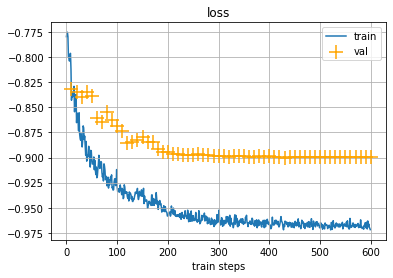

LR: 1.0000000000000002e-07
Train score: 0.9717472791671753
Last Val score: 0.8995803395907084
Best Val score: 0.9003016948699951


In [48]:
best_model = None
best_model, val_score = train(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader, 
    60
)

## Посчитаем метрику

In [49]:
model.eval()
best_model.eval()
print()

In [50]:
preds = []
gt = []
with torch.no_grad():
    for _, imgs, labels in valid_loader:
        
        if IS_CNN:
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred = model(imgs)
        else:
            for i in imgs:
                imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            pred = model(imgs)

        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())
_compute_metric(gt, preds)

0.9141634343069059

In [51]:
preds = []
gt = []
with torch.no_grad():
    for _, imgs, labels in valid_loader:
        
        if IS_CNN:
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred = best_model(imgs)
        else:
            for i in imgs:
                imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            pred = best_model(imgs)

        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())
_compute_metric(gt, preds)

0.9150612539297942

In [30]:
# levit123s - 0.8037
# levit192 - 0.8003


# CatBoost Aggregation

In [22]:
from catboost import CatBoostRegressor

sigmoid = torch.nn.Sigmoid()

class TestData(Dataset):
    def __init__(self, images_paths, feature_extractor=None, transform=None):
        self.feature_extractor = feature_extractor
        self.images_paths = images_paths
        self.transform = transform

    def __getitem__(self, idx):
        image = cv2.imread(str(self.images_paths[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.feature_extractor is not None:
            image = self.feature_extractor(images=image, return_tensors="pt")
        else:
            image = self.transform(image)

        return int(str(self.images_paths[idx].name).split(".")[0]), image
        
    def __len__(self):
        return len(self.images_paths)

models_weights = [
    "best_res50_clouds_0.91.pth", 
    "best_effb3_clouds_0.92.pth", 
    "best_levit128S_clouds_0.82.pth", 
    "best_vit_clouds_0.83.pth", 
    "best_swin_clouds_0.83.pth"
]
img_sizes = [
    224, 
    300, 
    224, 
    224, 
    224
]

In [23]:
cv_models = []

model_name = "resnet50"
model = CNN("res50")
model.load_state_dict(torch.load(models_weights[0]))
cv_models.append({"name": "cnn", "model": model, "feature_extractor": None})

model_name = "effb3"
model = CNN("effb3")
model.load_state_dict(torch.load(models_weights[1]))
cv_models.append({"name": "cnn", "model": model, "feature_extractor": None})

model_name = "facebook/levit-128S"
model = TrNN("levit")
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model.load_state_dict(torch.load(models_weights[2]))
cv_models.append({"name": "transformer", "model": model, "feature_extractor": feature_extractor})

model_name = "google/vit-base-patch16-224"
model = TrNN("vit")
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model.load_state_dict(torch.load(models_weights[3]))
cv_models.append({"name": "transformer", "model": model, "feature_extractor": feature_extractor})

model_name = "microsoft/swin-tiny-patch4-window7-224"
model = TrNN("swin")
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model.load_state_dict(torch.load(models_weights[4]))
cv_models.append({"name": "transformer", "model": model, "feature_extractor": feature_extractor})


for model in cv_models:
    model["model"].to(device)
    model["model"].eval()

Some weights of the model checkpoint at facebook/levit-128S were not used when initializing LevitForImageClassification: ['classifier_distill.batch_norm.bias', 'classifier_distill.batch_norm.num_batches_tracked', 'classifier_distill.batch_norm.running_mean', 'classifier_distill.linear.bias', 'classifier_distill.linear.weight', 'classifier_distill.batch_norm.weight', 'classifier_distill.batch_norm.running_var']
- This IS expected if you are initializing LevitForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LevitForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/and/miniforge3/envs/mipt-hack/lib/python3.9/site-packages/torch/functional.py:478: UserWarn

In [25]:
# generate train_df
def generate_preds_df(model_num, pred_df, model, dataset):
    rows = []
    for img_id, img, labels in tqdm(dataset):
        labels = labels.tolist()
        with torch.no_grad():
            if is_cnn:
                img = img.unsqueeze(0).to(device, non_blocking=True)
                pred = model["model"](img).squeeze(0).cpu().tolist()
            else:
                for i in img:
                    img[i] = img[i].to(device, non_blocking=True)
                pred = model["model"](img).squeeze(0).cpu().tolist()
            row = {
                'id': img_id, 
                "left_top_x": pred[0], 
                'left_top_y': pred[1], 
                "right_bottom_x": pred[2], 
                'right_bottom_y': pred[3], 
                'angle': pred[4],
                "gt_left_top_x": labels[0], 
                'gt_left_top_y': labels[1], 
                "gt_right_bottom_x": labels[2], 
                'gt_right_bottom_y': labels[3], 
                'gt_angle': labels[4],
            }
            rows.append(row)
    data_df = pd.DataFrame(rows)
    if model_num == 0:
        pred_df = data_df
    else:
        data_df = data_df.drop(["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)
        pred_df = pred_df.merge(
            data_df, 
            on="id", 
            suffixes=("", f"_{model_num}")
        )

    return pred_df


pred_train_df = None
pred_valid_df = None

for model_num, (model, img_size) in enumerate(zip(cv_models, img_sizes)):
    is_cnn = model["name"] == "cnn"

    train_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])
    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = ImageDataset(train_df, transform=train_transform, feature_extractor=model["feature_extractor"])
    valid_dataset = ImageDataset(valid_df, transform=test_transform, feature_extractor=model["feature_extractor"])

    pred_train_df = generate_preds_df(model_num, pred_train_df, model, train_dataset)
    pred_valid_df = generate_preds_df(model_num, pred_valid_df, model, valid_dataset)

    print(f"Model {model_num} predictions generated!")


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 0 predictions generated!


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 1 predictions generated!


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 2 predictions generated!


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 3 predictions generated!


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 4 predictions generated!


In [19]:
# pred_train_df.to_csv("../data/agg_pred/train.csv", index=False)
# pred_valid_df.to_csv("../data/agg_pred/valid.csv", index=False)

In [20]:
# pred_train_df = pd.read_csv("../data/agg_pred/train.csv")
# pred_valid_df = pd.read_csv("../data/agg_pred/valid.csv")

In [34]:
# # Train AGG Regressor

class Regressor(nn.Module):
  def __init__(self, in_features=25):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features, 512),
      nn.ELU(),
      nn.Linear(512, 256),
      nn.ELU(),
      nn.Linear(256, 64),
      nn.ELU(),
      nn.Linear(64, 32),
      nn.ELU(),
      nn.Linear(32, 5),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)


pred_train_data = pred_train_df.drop(["id", "gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)
pred_valid_data = pred_valid_df.drop(["id", "gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)

gt_train = pred_train_df[["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"]]
gt_valid = pred_valid_df[["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"]]


#### CAT
# regressor = CatBoostRegressor(
#     loss_function='MultiRMSE',
#     iterations=2500,
# )

# regressor.fit(pred_train_data, gt_train, eval_set=(pred_valid_data, gt_valid), verbose=1)
# print("Saving model")
# regressor.save_model("regressor.cbm")


### NN
regressor = Regressor(pred_train_data.shape[-1])
regressor.to(device)
criterion = TorchLoss()
optimizer = torch.optim.AdamW(regressor.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=300, verbose=True)
train_metrics, val_metrics = [], []
best_score = 0
for epoch in tqdm(range(5000)):
    regressor.train()
    train_pred = []
    data = torch.from_numpy(pred_train_data.values).float().to(device)
    labels = torch.from_numpy(gt_train.values).float().to(device)
    pred = regressor(data)
    loss = criterion(pred, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_pred.extend(pred.cpu().tolist())


    regressor.eval()
    val_pred = []
    with torch.no_grad():
        data = torch.from_numpy(pred_valid_data.values).float().to(device)
        pred = regressor(data)        
        val_pred.extend(pred.cpu().tolist())

    train_metrics.append(_compute_metric(gt_train.values, train_pred))
    val_metrics.append(_compute_metric(gt_valid.values, val_pred))

    if val_metrics[-1] > best_score:
        best_regressor = deepcopy(regressor)
        best_score = val_metrics[-1]

    # scheduler.step(val_metrics[-1])

    print('Last Train score:', train_metrics[-1], ' Best Val score:', max(val_metrics))


  0%|          | 0/5000 [00:00<?, ?it/s]

Last Train score: 0.777772142185449  Best Val score: 0.7968079829025978
Last Train score: 0.7863486841338791  Best Val score: 0.8006824253327995
Last Train score: 0.7931834483545719  Best Val score: 0.8034975772091585
Last Train score: 0.7996520313773199  Best Val score: 0.8072488985127068
Last Train score: 0.8067318939178534  Best Val score: 0.8130593774532202
Last Train score: 0.8151938508650107  Best Val score: 0.8213062431644478
Last Train score: 0.8251297932874069  Best Val score: 0.8305350786229738
Last Train score: 0.8360553979333528  Best Val score: 0.8392641209070252
Last Train score: 0.8472197455422691  Best Val score: 0.84731217955994
Last Train score: 0.8573895262441317  Best Val score: 0.8544162783868645
Last Train score: 0.866921302074147  Best Val score: 0.8615954393027817
Last Train score: 0.8757150482601747  Best Val score: 0.8671690699087614
Last Train score: 0.8842135658351461  Best Val score: 0.8702938259739766
Last Train score: 0.8918590980694173  Best Val score: 0

KeyboardInterrupt: 

In [24]:
# 0.8960
# 8998

In [35]:
# Validation

# val_prediction = regressor.predict(pred_valid_data)
# _compute_metric(gt_valid.values, val_prediction)

best_regressor.eval()
with torch.no_grad():
    val_prediction = best_regressor(torch.from_numpy(pred_valid_data.values).float().to(device)).cpu().tolist()
_compute_metric(gt_valid.values, val_prediction)

0.9234693820187704

In [36]:
torch.save(best_regressor.state_dict(), "best_regressor.pth")

# Inference

In [37]:
def generate_preds_df_test(model_num, pred_df, model, dataset):
    rows = []
    for img_id, img in tqdm(dataset):
        with torch.no_grad():
            if model["name"] == "cnn":
                img = img.unsqueeze(0).to(device, non_blocking=True)
                pred = model["model"](img).squeeze(0).cpu().tolist()
            else:
                for i in img:
                    img[i] = img[i].to(device, non_blocking=True)
                pred = model["model"](img).squeeze(0).cpu().tolist()
            row = {
                'id': img_id, 
                "left_top_x": pred[0], 
                'left_top_y': pred[1], 
                "right_bottom_x": pred[2], 
                'right_bottom_y': pred[3], 
                'angle': pred[4],
            }
            rows.append(row)
    data_df = pd.DataFrame(rows)
    if model_num == 0:
        pred_df = data_df
    else:
        pred_df = pred_df.merge(
            data_df, 
            on="id", 
            suffixes=("", f"_{model_num}")
        )

    return pred_df


In [38]:
images_paths = sorted(list(Path("../data/test").iterdir()), key = lambda p: int(p.name[:-4]))

pred_test_df = None
for model_num, (model, img_size) in enumerate(zip(cv_models, img_sizes)):

    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    test_dataset = TestData(images_paths, model["feature_extractor"], test_transform)

    pred_test_df = generate_preds_df_test(model_num, pred_test_df, model, test_dataset)

    print(f"Model {model_num} predictions generated!")

  0%|          | 0/400 [00:00<?, ?it/s]

Model 0 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 1 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 2 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 3 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 4 predictions generated!


In [39]:
pred_test_df.head()

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle,left_top_x_1,left_top_y_1,right_bottom_x_1,right_bottom_y_1,...,left_top_x_3,left_top_y_3,right_bottom_x_3,right_bottom_y_3,angle_3,left_top_x_4,left_top_y_4,right_bottom_x_4,right_bottom_y_4,angle_4
0,3,0.690710,0.537873,0.483925,0.789046,0.624186,0.657420,0.612765,0.614648,0.590196,...,0.437761,0.329714,0.304511,0.567042,0.448887,0.471740,0.772388,0.608818,0.648354,0.504758
1,4,0.803843,0.246903,0.845455,0.356007,0.575214,0.714535,0.236132,0.769722,0.307520,...,0.481827,0.212716,0.384841,0.477099,0.491592,0.416479,0.436176,0.760627,0.307632,0.539582
2,5,0.409440,0.419528,0.267265,0.588808,0.344566,0.183480,0.524957,0.436869,0.520302,...,0.406606,0.334640,0.275658,0.552410,0.435744,0.525270,0.794900,0.626842,0.691994,0.514785
3,10,0.508861,0.653909,0.236744,0.849556,0.396855,0.413240,0.836410,0.437473,0.727218,...,0.856954,0.822522,0.136312,0.908807,0.560908,0.477439,0.860430,0.526363,0.765548,0.548060
4,11,0.577846,0.201263,0.632330,0.352004,0.771420,0.793203,0.144130,0.681838,0.258728,...,0.679736,0.124474,0.603573,0.444787,0.567666,0.437877,0.427200,0.772185,0.309150,0.529872


In [40]:
ids = pred_test_df.id
# prediction = regressor.predict(pred_test_df.drop("id", axis=1))
with torch.no_grad():
    prediction = best_regressor(torch.from_numpy(pred_test_df.drop("id", axis=1).values).float().to(device)).cpu().tolist()

In [41]:
submit_folder = Path("../data/agg_submit/")
for img_id, pred in tqdm(zip(ids, prediction), total=len(ids)):
    res = {
        "left_top": [pred[0] * IMG_SIZE, pred[1] * IMG_SIZE],
        "right_top": [pred[2] * IMG_SIZE, pred[1] * IMG_SIZE],
        "left_bottom": [pred[0] * IMG_SIZE, pred[3] * IMG_SIZE],
        "right_bottom": [pred[2] * IMG_SIZE, pred[3] * IMG_SIZE],
        "angle": pred[4] * 360
    }
    
    with open(submit_folder / f"{img_id}.json", "w") as f:
        json.dump(res, f)

  0%|          | 0/400 [00:00<?, ?it/s]